### Libraries

In [ ]:
import pandas as pd
import random
import numpy as np

### Import data

#### Full data

In [74]:
full_data = pd.read_csv("../data/scored_tweets_final_translated_with_network_analytics.csv")

In [3]:
full_data.head()

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,user_pumper_probability,...,is_retweet,retweet_count,mentions_by_others,tweet_frequency_1d,frequency_change_1d,tweet_frequency_3d,frequency_change_3d,degree_centrality,betweenness_centrality,eigenvector_centrality
0,SOL,2021-03-29 08:46:02+00:00,00FF00008000,1376455596807872520a,RT @CryptoCrunchApp: Checkout Top 10 #trending...,1,0,0.0,NaN,0.025278,...,True,1,0,1,0,1,0,0.000982,0.0,0.000008
1,GYST,2021-03-29 19:02:16+00:00,01stocksavage,1376610677016702980a,RT @timothysykes: https://t.co/HhjTliF1dw Well...,1,0,0.0,NaN,0.025278,...,True,1,0,1,0,1,0,0.000245,0.0,0.000008
2,SOL,2021-03-30 23:50:30+00:00,020626susu,1377045600462544896a,"RT @yocchan60: Rather than aiming to get 100,0...",1,0,0.0,NaN,0.038038,...,True,1,0,1,0,1,0,0.000245,0.0,0.000008
3,SOL,2021-03-28 07:01:22+00:00,0520tamasan1972,1376066867941449733a,RT @yocchan60: #solana $SOL The creases are ri...,1,0,1.0,NaN,0.038038,...,True,1,0,1,0,1,0,0.000245,0.0,0.000008
4,SOL,2021-03-28 09:36:58+00:00,0520tamasan1972,1376106026642993162a,"RT @yocchan60: Rather than aiming to get 100,0...",1,0,1.0,NaN,0.038038,...,True,1,0,2,1,2,1,0.000245,0.0,0.000008


In [75]:
sum(full_data["Known_Pumper"])

360

#### Flagged data (Original dataset)

In [70]:
flagged_data = pd.read_csv("../data/flagged_tweets.csv", index_col=0)

In [71]:
flagged_data.head()

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,user_pumper_probability,hashtag_count,emoji_count,keyword_count,stock_ticker_count,url_count,pumper_category
9372,EEENF,2021-04-06 15:04:17+00:00,HarryPainter20,1379449890779041793a,@anti_warhawk If you lost money on $EEENF it i...,-1,0,-1.0,NaN,0.025278,0,0,0,1,1,0
3770,TTCM,2021-03-29 18:03:15+00:00,OTC_ARMY,1376595826231795714a,$PACV to Acquire a $40 Million Food and Bevera...,1,0,0.0,NaN,0.025278,0,0,0,1,2,0
4513,EEENF,2021-03-24 16:30:48+00:00,OTC_ARMY,1374760620101234688a,$AGYP @AlliedEnergyCo1 #AGYP 80% revenue inter...,0,1,1.0,NaN,0.800000,3,0,0,1,2,1
579,DPLN,2021-03-24 18:16:29+00:00,bwatts_81,1374787218481369088a,@rsweetchaos613 $DPLN appears to be done. It f...,-1,0,0.0,NaN,0.025278,0,0,1,1,1,0
6381,EEENF,2021-03-31 13:50:50+00:00,AlexDelarge6553,1377257079723978757a,10 CENTS $EEENF TODAY! https://t.co/d8kAZfkTQi,1,1,1.0,NaN,0.800000,0,0,0,1,1,1


##### How many actual pumpers

% Precision

In [72]:
flagged_data.shape

(96, 16)

In [55]:
sum(flagged_data["Known_Pumper"].values)/96*100

25.0

In [ ]:
y_true = flagged_data["Known_Pumper"]

##### Viewing non-pumpers tweets that cause them to be flagged

In [62]:
random.seed(33)

random.sample(list(flagged_data[flagged_data["Known_Pumper"] == 0]["text"]),5)

['$CYAN $CPHI - broken stocks. short outer line and near vwap. once confirmed, add to my winners.\n\n$SEAC - not watch… https://t.co/sY1TRiwzsH',
 '$TTCM https://t.co/lC87OZT5vH',
 '$HPNN @HPNN \nBe ready ceo said he is dropping another bomb. Get ready to fucked up again. \n$GTLL $INND $ILUS $EEENF… https://t.co/QT7uJx78Nh',
 'ITS HERE! $EEENF https://t.co/taL21SaAhQ',
 '$EEENF WILL YOU HELP OUT SHAREHOLDERS?? atleast reach out?? Pr style?? https://t.co/mtMpvSQmtW']

These are some of the people who are not KNOWN pumpers, but our model has flagged as suspicious. Honestly speaking, looking at it from this perspective, these tweets look rather suspicious as well

#### Running network analysis on this filtered subset

In [63]:
flagged_usernames = list(np.unique(list(flagged_data["user.screen_name"])))

In [64]:
def filter_dataframe_by_usernames(df, usernames_list, username_column_name):
  """
  Filters a DataFrame to keep only rows where the value in the specified
  username column is present in the provided list of unique usernames.

  Args:
    df: The pandas DataFrame to filter.
    usernames_list: A list of unique usernames.
    username_column_name: The name of the column in the DataFrame containing usernames.

  Returns:
    A filtered pandas DataFrame.
  """

  filtered_df = df[df[username_column_name].isin(usernames_list)]
  return filtered_df

def keep_unique_usernames(df, username_column_name):
  """
  Filters a DataFrame to keep only the first row for each unique username.

  Args:
    df: The pandas DataFrame to filter.
    username_column_name: The name of the column containing usernames.

  Returns:
    A filtered pandas DataFrame with unique usernames.
  """

  unique_df = df.drop_duplicates(subset=username_column_name, keep='first')
  return unique_df

filtered_dataframe_by_username = filter_dataframe_by_usernames(full_data,flagged_usernames,"user.screen_name")
unique_filtered_dataframe_by_username = keep_unique_usernames(filtered_dataframe_by_username,"user.screen_name")

In [65]:
filtered_dataframe_by_username

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,user_pumper_probability,...,is_retweet,retweet_count,mentions_by_others,tweet_frequency_1d,frequency_change_1d,tweet_frequency_3d,frequency_change_3d,degree_centrality,betweenness_centrality,eigenvector_centrality
298,EEENF,2021-03-24 10:49:50+00:00,AlexDelarge6553,1374674814250725381a,Wednesday stocks that rock\n1 $tggi \n2 $icbu ...,1,1,1.0,NaN,0.800000,...,False,0,217,1,0,1,0,0.044183,0.014048,0.376295
299,EEENF,2021-03-24 12:58:25+00:00,AlexDelarge6553,1374707171548663810a,RT @AlexDelarge6553: Wednesday stocks that roc...,1,1,1.0,NaN,0.800000,...,True,1,217,2,1,2,1,0.044183,0.014048,0.376295
300,EEENF,2021-03-24 20:39:45+00:00,AlexDelarge6553,1374823271296872453a,@Bennyhills12345 @JAN3T_R @meihuaxu Benny be c...,0,1,1.0,NaN,0.800000,...,False,0,217,3,1,3,1,0.044183,0.014048,0.376295
301,EEENF,2021-03-24 22:45:58+00:00,AlexDelarge6553,1374855033699860480a,Thursday list! Sorry its what I do. \n\n1 $skd...,1,1,1.0,NaN,0.800000,...,False,0,217,4,1,4,1,0.044183,0.014048,0.376295
302,EEENF,2021-03-24 23:17:44+00:00,AlexDelarge6553,1374863031080001538a,@TylerBlackPine @BOOLINBOOLIN1 $eeenf at open,0,1,1.0,NaN,0.800000,...,False,0,217,5,1,5,1,0.044183,0.014048,0.376295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9845,WNRS,2021-03-25 19:13:19+00:00,vegaswinnersinc,1375163908525322243a,$WNRS Former CEO of https://t.co/4KFTTdcFfm an...,0,0,0.0,NaN,0.025278,...,False,0,8,2,1,3,1,0.001227,0.000000,0.001095
9948,TTCM,2021-03-25 12:13:02+00:00,wolftrader670,1375058139775651840a,$ALGO ers get some dd done on $ttcm. Long both...,1,0,0.0,NaN,0.025278,...,False,0,0,1,0,1,0,0.000000,0.000000,0.000008
9949,TTCM,2021-03-25 21:34:46+00:00,wolftrader670,1375199506057334784a,$TTCM I see a major partner/partners coming o...,1,0,0.0,NaN,0.025278,...,False,0,0,2,1,2,1,0.000000,0.000000,0.000008
9950,TTCM,2021-03-29 17:19:09+00:00,wolftrader670,1376584728258678790a,$TTCM News https://t.co/3EYyK706nI,0,0,0.0,NaN,0.025278,...,False,0,0,1,-1,1,-1,0.000000,0.000000,0.000008


#### Testing the model

In [32]:
import joblib

In [48]:
xgboost_model_2 = joblib.load("../model_training/models/network_analysis_XGBoost_model_2.joblib")

##### X and Y

In [66]:
features = [
    'handles_mentioned',
    'retweet_count',
    'mentions_by_others',
    'frequency_change_1d',
    'frequency_change_3d',
    'degree_centrality',
    'betweenness_centrality',
    'eigenvector_centrality'
]

X = filtered_dataframe_by_username[features]

# Create y (target variable)
y = filtered_dataframe_by_username['Known_Pumper']


##### Code to run the model

In [67]:
predictions = xgboost_model_2.predict(X)

# Print the predictions (or use them as needed)
filtered_dataframe_by_username["predictions"] = predictions

/var/folders/q3/p7x07_8d2b9fv9qcmf0s6wyc0000gn/T/ipykernel_1282/772160028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframe_by_username["predictions"] = predictions


In [68]:
def propagate_pumper_flag(df, username_column, prediction_column):
    """
    Propagates the pumper flag (prediction = 1) across all tweets of the same user.

    Args:
        df: The pandas DataFrame with user data and predictions.
        username_column: The name of the column containing usernames.
        prediction_column: The name of the column containing predictions (0 or 1).

    Returns:
        A pandas DataFrame with propagated pumper flags.
    """

    def propagate_for_user(user_df):
        if 1 in user_df[prediction_column].values:
            user_df[prediction_column] = 1
        return user_df

    df = df.groupby(username_column).apply(propagate_for_user)
    return df

propagated_df = propagate_pumper_flag(filtered_dataframe_by_username, 'user.screen_name', 'predictions')

# Print the result
propagated_df

/var/folders/q3/p7x07_8d2b9fv9qcmf0s6wyc0000gn/T/ipykernel_1282/3737718056.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(username_column).apply(propagate_for_user)


Stock                   Datetime user.screen_name  \
user.screen_name                                                           
AlexDelarge6553  298   EEENF  2021-03-24 10:49:50+00:00  AlexDelarge6553   
                 299   EEENF  2021-03-24 12:58:25+00:00  AlexDelarge6553   
                 300   EEENF  2021-03-24 20:39:45+00:00  AlexDelarge6553   
                 301   EEENF  2021-03-24 22:45:58+00:00  AlexDelarge6553   
                 302   EEENF  2021-03-24 23:17:44+00:00  AlexDelarge6553   
...                      ...                        ...              ...   
vegaswinnersinc  9845   WNRS  2021-03-25 19:13:19+00:00  vegaswinnersinc   
wolftrader670    9948   TTCM  2021-03-25 12:13:02+00:00    wolftrader670   
                 9949   TTCM  2021-03-25 21:34:46+00:00    wolftrader670   
                 9950   TTCM  2021-03-29 17:19:09+00:00    wolftrader670   
                 9951   TTCM  2021-03-29 20:03:48+00:00    wolftrader670   

                                     id_str  \
user.screen_name                              
AlexDelarge6553  298   1374674814250725381a   
                 299   1374707171548663810a   
                 300   1374823271296872453a   
                 301   1374855033699860480a   
                 302   1374863031080001538a   
...                                     ...   
vegaswinnersinc  9845  1375163908525322243a   
wolftrader670    9948  1375058139775651840a   
                 9949  1375199506057334784a   
                 9950  1376584728258678790a   
                 9951  1376626164257669120a   

                                                                    text  \
user.screen_name                                                           
AlexDelarge6553  298   Wednesday stocks that rock\n1 $tggi \n2 $icbu ...   
                 299   RT @AlexDelarge6553: Wednesday stocks that roc...   
                 300   @Bennyhills12345 @JAN3T_R @meihuaxu Benny be c...   
                 301   Thursday list! Sorry its what I do. \n\n1 $skd...   
                 302       @TylerBlackPine @BOOLINBOOLIN1 $eeenf at open   
...                                                                  ...   
vegaswinnersinc  9845  $WNRS Former CEO of https://t.co/4KFTTdcFfm an...   
wolftrader670    9948  $ALGO ers get some dd done on $ttcm. Long both...   
                 9949  $TTCM I see a major partner/partners  coming o...   
                 9950                 $TTCM News https://t.co/3EYyK706nI   
                 9951  $TTCM The Tautachrome ACE is the first fully d...   

                       Sentiment  Known_Pumper  Price_Region  \
user.screen_name                                               
AlexDelarge6553  298           1             1           1.0   
                 299           1             1           1.0   
                 300           0             1           1.0   
                 301           1             1           1.0   
                 302           0             1           1.0   
...                          ...           ...           ...   
vegaswinnersinc  9845          0             0           0.0   
wolftrader670    9948          1             0           0.0   
                 9949          1             0           0.0   
                 9950          0             0           0.0   
                 9951          1             0          -1.0   

                       Inflection_Point  user_pumper_probability  ...  \
user.screen_name                                                  ...   
AlexDelarge6553  298                NaN                 0.800000  ...   
                 299                NaN                 0.800000  ...   
                 300                NaN                 0.800000  ...   
                 301                NaN                 0.800000  ...   
                 302                NaN                 0.800000  ...   
...                                 ...                      ...  ...   
vegaswinnersinc 

Accuracy: 0.8695
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90       617
           1       0.67      1.00      0.80       226

    accuracy                           0.87       843
   macro avg       0.84      0.91      0.85       843
weighted avg       0.91      0.87      0.88       843



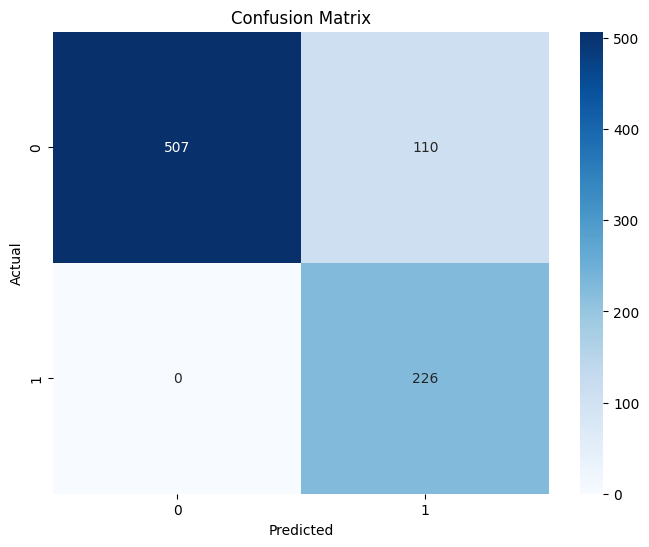

In [69]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = propagated_df['Known_Pumper']
y_pred = propagated_df['predictions']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()